#you need to install this first 

pip install mamba-ssm[causal-conv1d] --no-build-isolation

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from mamba_ssm import Mamba
from sklearn.model_selection import train_test_split

print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA available: True


In [2]:
# Load data
df = pd.read_csv("/home/khanteyl/polymers/Tg_subset_not_nan.csv")
smiles_list = df["SMILES"].astype(str).tolist()
tg_list = df["Tg"].astype(float).tolist()
print(f"Loaded {len(smiles_list)} samples")

Loaded 511 samples


# Build SMILES Tokenizer (Improved Version)
**Using improved tokenizer that handles multi-character atoms and SMILES patterns**

In [3]:
# Improved SMILES Tokenizer
# Handles multi-character atoms (Cl, Br, [NH], etc.) and ring numbers properly

def improved_smiles_tokenizer(smiles):
    """
    Tokenizes SMILES by handling:
    - Multi-character atoms (Cl, Br, etc.)
    - Bracketed atoms ([NH], [Cl], [C+], etc.)
    - Ring numbers (1, 12, etc.)
    """
    tokens = []
    i = 0
    n = len(smiles)
    
    while i < n:
        char = smiles[i]
        
        # Handle bracketed atoms: [NH], [Cl], [C+], [13C], etc.
        if char == '[':
            end = smiles.find(']', i)
            if end != -1:
                tokens.append(smiles[i:end+1])  # Include brackets
                i = end + 1
                continue
        
        # Handle two-letter atoms: Cl, Br, etc.
        if i < n - 1 and char.isupper() and smiles[i+1].islower():
            tokens.append(smiles[i:i+2])
            i += 2
            continue
        
        # Handle ring numbers (can be 1-2 digits)
        if char.isdigit():
            if i < n - 1 and smiles[i+1].isdigit():
                tokens.append(smiles[i:i+2])  # Two-digit ring number
                i += 2
            else:
                tokens.append(char)  # Single digit
                i += 1
            continue
        
        # Handle other characters (single atoms, bonds, etc.)
        tokens.append(char)
        i += 1
    
    return tokens

# Build vocabulary from all tokens
print("Building improved SMILES tokenizer...")
all_tokens = set()
for smiles in smiles_list:
    tokens = improved_smiles_tokenizer(smiles)
    all_tokens.update(tokens)

# Add special tokens
PAD = "<pad>"
BOS = "<bos>"
EOS = "<eos>"

itos = [PAD, BOS, EOS] + sorted(all_tokens)
stoi = {token: i for i, token in enumerate(itos)}

pad_idx = stoi[PAD]
bos_idx = stoi[BOS]
eos_idx = stoi[EOS]

vocab_size = len(itos)
print(f"Vocab size: {vocab_size} (improved from character-level)")

def encode_smiles(s: str, add_bos=True, add_eos=True):
    """Encode SMILES using improved tokenizer"""
    tokens = improved_smiles_tokenizer(s)
    encoded = []
    if add_bos:
        encoded.append(bos_idx)
    for token in tokens:
        encoded.append(stoi[token])
    if add_eos:
        encoded.append(eos_idx)
    return encoded

# Encode all SMILES
encoded = [encode_smiles(s) for s in smiles_list]
max_len = max(len(t) for t in encoded)

# Show comparison
char_level_len = sum(len(s) for s in smiles_list[:10]) / 10
improved_len = sum(len(encode_smiles(s)) for s in smiles_list[:10]) / 10

print(f"Max token length: {max_len}")
print(f"Average sequence length (sample): {improved_len:.1f} tokens (vs ~{char_level_len:.1f} character-level)")
print(f"\nExample tokenization:")
example = smiles_list[0]
print(f"  SMILES: {example}")
example_tokens = improved_smiles_tokenizer(example)
print(f"  Tokens: {example_tokens[:20]}..." if len(example_tokens) > 20 else f"  Tokens: {example_tokens}")


Building improved SMILES tokenizer...
Vocab size: 57 (improved from character-level)
Max token length: 179
Average sequence length (sample): 44.5 tokens (vs ~43.0 character-level)

Example tokenization:
  SMILES: *NC(C)C(=O)NCC(=O)NCC(*)=O
  Tokens: ['*', 'N', 'C', '(', 'C', ')', 'C', '(', '=', 'O', ')', 'N', 'C', 'C', '(', '=', 'O', ')', 'N', 'C']...


# Train/Val Split and Dataset

In [4]:
# Train/validation split
train_tokens, val_tokens, train_tg, val_tg = train_test_split(
    encoded, tg_list, test_size=0.2, random_state=42
)

# Normalize targets (compute stats from training set only)
train_tg_array = np.array(train_tg)
tg_mean = train_tg_array.mean()
tg_std = train_tg_array.std()
print(f"Tg statistics (from training set): mean={tg_mean:.2f}, std={tg_std:.2f}")

train_tg_normalized = [(t - tg_mean) / tg_std for t in train_tg]
val_tg_normalized = [(t - tg_mean) / tg_std for t in val_tg]

normalization_stats = {"mean": tg_mean, "std": tg_std}

# Dataset class
class SmilesTgDataset(Dataset):
    def __init__(self, token_lists, tg_values):
        self.token_lists = token_lists
        self.tg_values = tg_values

    def __len__(self):
        return len(self.token_lists)

    def __getitem__(self, idx):
        tokens = torch.tensor(self.token_lists[idx], dtype=torch.long)
        tg = torch.tensor(self.tg_values[idx], dtype=torch.float32)
        return tokens, tg

def collate_fn(batch):
    token_seqs, tgs = zip(*batch)
    lengths = [len(seq) for seq in token_seqs]
    max_len = max(lengths)

    padded = torch.full((len(batch), max_len), pad_idx, dtype=torch.long)
    for i, seq in enumerate(token_seqs):
        padded[i, :len(seq)] = seq

    tgs = torch.stack(tgs)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return padded, tgs, lengths

# Create datasets and loaders
train_dataset = SmilesTgDataset(train_tokens, train_tg_normalized)
val_dataset = SmilesTgDataset(val_tokens, val_tg_normalized)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")


Tg statistics (from training set): mean=98.75, std=114.14
Train samples: 408, Val samples: 103


In [5]:
# Training Functions
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    n_samples = 0

    for tokens, tgs, lengths in loader:
        tokens = tokens.to(device)
        tgs = tgs.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        preds = model(tokens, lengths)
        loss = criterion(preds, tgs)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        batch_size = tokens.size(0)
        total_loss += loss.item() * batch_size
        n_samples += batch_size

    return total_loss / n_samples

@torch.no_grad()
def evaluate_with_denorm(model, loader, criterion, device, tg_mean, tg_std):
    """Evaluate and compute R² on original (denormalized) scale"""
    model.eval()
    total_loss = 0.0
    n_samples = 0
    all_preds_norm = []
    all_targets_norm = []

    for tokens, tgs, lengths in loader:
        tokens = tokens.to(device)
        tgs = tgs.to(device)
        lengths = lengths.to(device)

        preds_norm = model(tokens, lengths)
        loss = criterion(preds_norm, tgs)

        batch_size = tokens.size(0)
        total_loss += loss.item() * batch_size
        n_samples += batch_size

        all_preds_norm.append(preds_norm.cpu())
        all_targets_norm.append(tgs.cpu())

    # Denormalize predictions and targets
    preds_norm = torch.cat(all_preds_norm)
    targets_norm = torch.cat(all_targets_norm)
    
    preds_orig = preds_norm * tg_std + tg_mean
    targets_orig = targets_norm * tg_std + tg_mean

    # Metrics on normalized scale
    mse_norm = total_loss / n_samples
    mae_norm = torch.mean(torch.abs(preds_norm - targets_norm)).item()

    # Metrics on original scale
    mse_orig = torch.mean((preds_orig - targets_orig)**2).item()
    mae_orig = torch.mean(torch.abs(preds_orig - targets_orig)).item()

    # R² on original scale
    ss_res = torch.sum((preds_orig - targets_orig)**2).item()
    ss_tot = torch.sum((targets_orig - targets_orig.mean())**2).item()
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0

    return mse_norm, mae_norm, mse_orig, mae_orig, r2


# Training Functions

# Improved Model: Larger Architecture for Better R²


In [6]:
# Mega Model: Much larger with better architecture
class MegaMambaRegressor(nn.Module):
    def __init__(self, vocab_size, d_model=512, d_state=16, d_conv=4, expand=2, 
                 pad_idx=0, n_layers=3, dropout=0.25):
        super().__init__()
        self.pad_idx = pad_idx

        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        
        # Stack multiple Mamba layers with residual connections
        self.mamba_layers = nn.ModuleList([
            Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(n_layers)
        ])
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(d_model) for _ in range(n_layers)
        ])
        
        # Multi-head attention pooling (more sophisticated)
        self.attention_pool = nn.MultiheadAttention(d_model, num_heads=8, dropout=dropout, batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
        
        # Very deep regression head with skip connections
        self.head1 = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.head2 = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.head3 = nn.Linear(d_model // 2, 1)

    def forward(self, tokens, lengths):
        # Embedding
        x = self.embed(tokens)  # (B, L, d_model)
        
        # Stacked Mamba layers with residual connections
        for mamba, norm in zip(self.mamba_layers, self.layer_norms):
            residual = x
            x = mamba(x)
            x = norm(x)
            x = self.dropout(x)
            x = x + residual
        
        # Multi-head attention pooling
        mask = (tokens != self.pad_idx)  # (B, L)
        attn_mask = ~mask  # True for padding
        
        # Use mean as query for pooling
        query = x.mean(dim=1, keepdim=True)  # (B, 1, d_model)
        pooled, _ = self.attention_pool(query, x, x, key_padding_mask=attn_mask)
        pooled = pooled.squeeze(1)  # (B, d_model)
        
        # Deep head with skip connections
        h1 = self.head1(pooled)
        h2 = self.head2(h1)
        out = self.head3(h2).squeeze(-1)  # (B,)
        return out

# Create mega model
model_mega = MegaMambaRegressor(
    vocab_size=vocab_size,
    d_model=512,  # 50% larger than 256
    d_state=16,
    d_conv=4,
    expand=2,
    pad_idx=pad_idx,
    n_layers=3,  # More layers
    dropout=0.25  # Higher dropout for regularization
).to(device)

# Combined loss (MSE + MAE) for robustness
class CombinedLoss(nn.Module):
    def __init__(self, mse_weight=0.7, mae_weight=0.3):
        super().__init__()
        self.mse_weight = mse_weight
        self.mae_weight = mae_weight
    
    def forward(self, pred, target):
        mse = nn.functional.mse_loss(pred, target)
        mae = nn.functional.l1_loss(pred, target)
        return self.mse_weight * mse + self.mae_weight * mae

criterion_mega = CombinedLoss(mse_weight=0.7, mae_weight=0.3)
optimizer_mega = torch.optim.AdamW(model_mega.parameters(), lr=2e-4, weight_decay=2e-4)  # Higher weight decay
scheduler_mega = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_mega, mode='min', factor=0.5, patience=10)

print(f"Mega model created: d_model=512, n_layers=3, multi-head attention")
print(f"Model parameters: {sum(p.numel() for p in model_mega.parameters()):,}")


Mega model created: d_model=512, n_layers=3, multi-head attention
Model parameters: 6,561,281


In [7]:
# Training Loop for Mega Model
num_epochs = 500
patience = 30  # Reduced patience - stop earlier to prevent overfitting
no_improve = 0

best_val_r2 = float("-inf")
best_state = None
best_epoch = 0

print("Starting training with MEGA model...")
print("=" * 80)

for epoch in range(1, num_epochs + 1):
    # Training
    train_mse = train_one_epoch(model_mega, train_loader, optimizer_mega, criterion_mega, device)
    
    # Validation
    val_mse_norm, val_mae_norm, val_mse_orig, val_mae_orig, val_r2 = evaluate_with_denorm(
        model_mega, val_loader, criterion_mega, device,
        normalization_stats["mean"], normalization_stats["std"]
    )
    
    # Learning rate scheduling
    scheduler_mega.step(val_mse_norm)
    current_lr = optimizer_mega.param_groups[0]['lr']
    
    # Print every 3 epochs or when R² improves
    if epoch % 3 == 0 or val_r2 > best_val_r2:
        print(
            f"Epoch {epoch:03d} | "
            f"train MSE: {train_mse:.4f} | "
            f"val R²: {val_r2:.4f} | "
            f"val MAE: {val_mae_orig:.2f}°C | "
            f"LR: {current_lr:.2e}"
        )

    # Check if validation R² improved
    if val_r2 > best_val_r2:
        improvement = val_r2 - best_val_r2
        best_val_r2 = val_r2
        best_epoch = epoch
        best_state = {
            "model": {k: v.cpu().clone() for k, v in model_mega.state_dict().items()},
            "stoi": stoi,
            "itos": itos,
            "normalization_stats": normalization_stats,
            "epoch": epoch,
            "val_r2": val_r2,
            "val_mae": val_mae_orig,
        }
        no_improve = 0
        if epoch % 3 != 0:
            print(f"Epoch {epoch:03d} | NEW BEST! R²: {val_r2:.4f} (improved by {improvement:.4f})")
    else:
        no_improve += 1

    # Early stopping
    if no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch} (no R² improvement for {patience} epochs)")
        print(f"Best R² was {best_val_r2:.4f} at epoch {best_epoch}")
        break

# Save best checkpoint
if best_state is not None:
    torch.save(best_state, "mamba_tg_regressor_mega.pt")
    print(f"\n{'='*80}")
    print(f"Training complete! Best R²: {best_val_r2:.4f} at epoch {best_epoch}")
    
    # Reload best model and verify
    model_mega.load_state_dict(best_state["model"])
    final_mse_norm, final_mae_norm, final_mse_orig, final_mae_orig, final_r2 = evaluate_with_denorm(
        model_mega, val_loader, criterion_mega, device,
        normalization_stats["mean"], normalization_stats["std"]
    )
    print(f"\nFinal Results:")
    print(f"  R²: {final_r2:.4f}")
    print(f"  MAE: {final_mae_orig:.2f}°C")
    print(f"  MSE: {final_mse_orig:.2f}")
    
else:
    print("No best state saved - training may have failed")


Starting training with MEGA model...
Epoch 001 | train MSE: 0.7405 | val R²: 0.4847 | val MAE: 54.56°C | LR: 2.00e-04
Epoch 001 | NEW BEST! R²: 0.4847 (improved by inf)
Epoch 003 | train MSE: 0.3883 | val R²: 0.5692 | val MAE: 51.19°C | LR: 2.00e-04
Epoch 005 | train MSE: 0.3662 | val R²: 0.6012 | val MAE: 48.69°C | LR: 2.00e-04
Epoch 005 | NEW BEST! R²: 0.6012 (improved by 0.0320)
Epoch 006 | train MSE: 0.3397 | val R²: 0.3741 | val MAE: 60.59°C | LR: 2.00e-04
Epoch 009 | train MSE: 0.2490 | val R²: 0.4115 | val MAE: 58.69°C | LR: 2.00e-04
Epoch 012 | train MSE: 0.2697 | val R²: 0.3407 | val MAE: 62.19°C | LR: 2.00e-04
Epoch 015 | train MSE: 0.1787 | val R²: 0.3787 | val MAE: 61.73°C | LR: 2.00e-04
Epoch 018 | train MSE: 0.1359 | val R²: 0.3783 | val MAE: 59.08°C | LR: 1.00e-04
Epoch 021 | train MSE: 0.1102 | val R²: 0.3739 | val MAE: 59.33°C | LR: 1.00e-04
Epoch 024 | train MSE: 0.1161 | val R²: 0.3023 | val MAE: 64.92°C | LR: 1.00e-04
Epoch 027 | train MSE: 0.0926 | val R²: 0.3179 |

# Parity Plot: Predicted vs Actual Tg


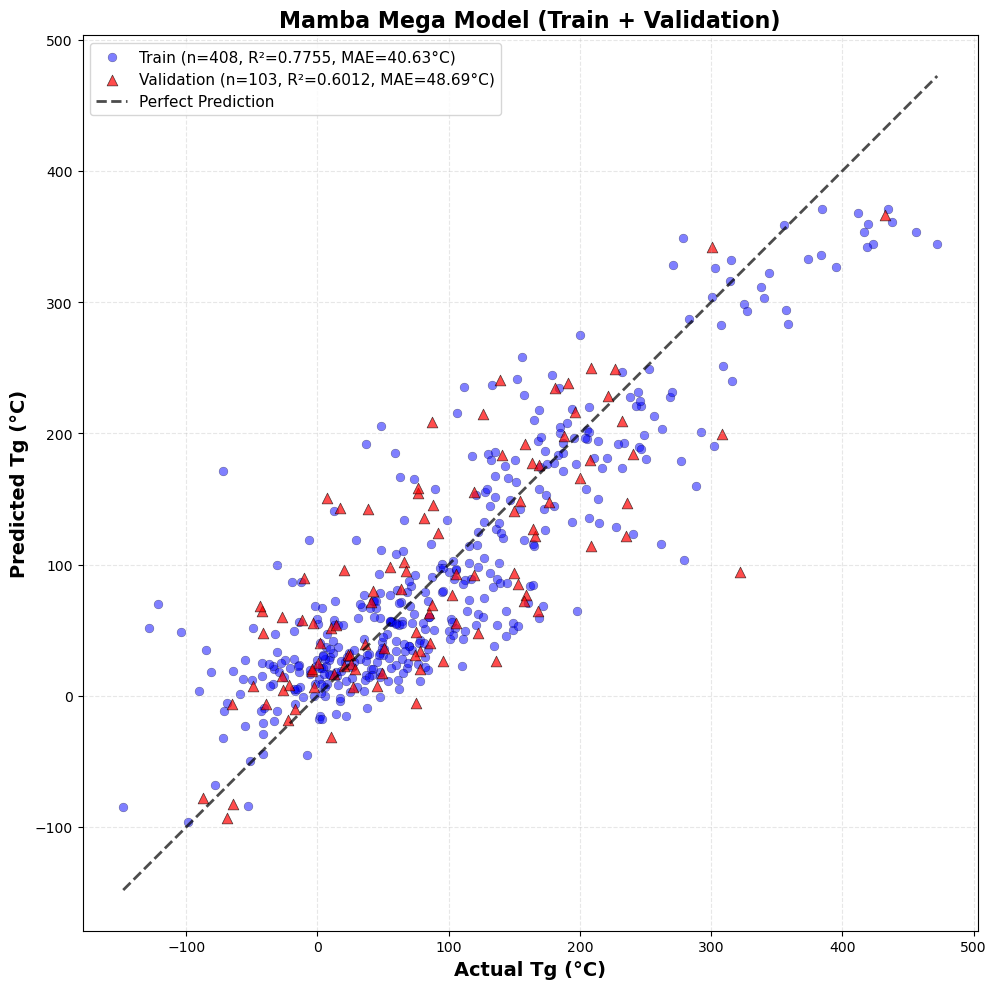


Train Set Metrics:
  R²: 0.7755
  MAE: 40.63°C
  RMSE: 54.08°C
  Samples: 408

Validation Set Metrics:
  R²: 0.6012
  MAE: 48.69°C
  RMSE: 61.70°C
  Samples: 103


In [8]:
import matplotlib.pyplot as plt
# Parity Plot with Both Train and Validation Sets
@torch.no_grad()
def get_all_predictions(model_or_models, train_loader, val_loader, device, tg_mean, tg_std, is_ensemble=False):
    """Get predictions for both train and validation sets"""
    if is_ensemble:
        for model in model_or_models:
            model.eval()
    else:
        model_or_models.eval()
    
    def get_preds_from_loader(loader):
        all_preds_norm = []
        all_targets_norm = []
        
        for tokens, tgs, lengths in loader:
            tokens = tokens.to(device)
            tgs = tgs.to(device)
            lengths = lengths.to(device)
            
            if is_ensemble:
                preds_list = []
                for model in model_or_models:
                    pred = model(tokens, lengths)
                    preds_list.append(pred)
                preds_norm = torch.stack(preds_list).mean(dim=0)
            else:
                preds_norm = model_or_models(tokens, lengths)
            
            all_preds_norm.append(preds_norm.cpu())
            all_targets_norm.append(tgs.cpu())
        
        preds_norm = torch.cat(all_preds_norm)
        targets_norm = torch.cat(all_targets_norm)
        preds_orig = preds_norm * tg_std + tg_mean
        targets_orig = targets_norm * tg_std + tg_mean
        return preds_orig.numpy(), targets_orig.numpy()
    
    train_preds, train_actuals = get_preds_from_loader(train_loader)
    val_preds, val_actuals = get_preds_from_loader(val_loader)
    
    return train_preds, train_actuals, val_preds, val_actuals

# Get predictions for both sets
use_ensemble = False  # Set to True for ensemble

if use_ensemble and 'models' in locals() and len(models) > 0:
    train_preds, train_actuals, val_preds, val_actuals = get_all_predictions(
        models, train_loader, val_loader, device,
        normalization_stats["mean"], normalization_stats["std"], is_ensemble=True
    )
    model_name = "Ensemble"
else:
    model_to_use = model_mega if 'model_mega' in locals() else model
    train_preds, train_actuals, val_preds, val_actuals = get_all_predictions(
        model_to_use, train_loader, val_loader, device,
        normalization_stats["mean"], normalization_stats["std"], is_ensemble=False
    )
    model_name = "Mega Model" if 'model_mega' in locals() else "Deep Model"

# Calculate metrics
def calc_metrics(preds, actuals):
    mse = np.mean((preds - actuals)**2)
    mae = np.mean(np.abs(preds - actuals))
    rmse = np.sqrt(mse)
    ss_res = np.sum((preds - actuals)**2)
    ss_tot = np.sum((actuals - actuals.mean())**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0
    return r2, mae, rmse

train_r2, train_mae, train_rmse = calc_metrics(train_preds, train_actuals)
val_r2, val_mae, val_rmse = calc_metrics(val_preds, val_actuals)

# Create parity plot with both sets
plt.figure(figsize=(12, 10))

# Plot train and validation
plt.scatter(
    train_actuals, train_preds,
    alpha=0.5, s=40, color='blue',
    edgecolors='black', linewidth=0.3,
    label=f'Train (n={len(train_preds)}, R²={train_r2:.4f}, MAE={train_mae:.2f}°C)'
)

plt.scatter(
    val_actuals, val_preds,
    alpha=0.7, s=60, color='red',
    edgecolors='black', linewidth=0.5, marker='^',
    label=f'Validation (n={len(val_preds)}, R²={val_r2:.4f}, MAE={val_mae:.2f}°C)'
)


# Add diagonal line
all_actuals = np.concatenate([train_actuals, val_actuals])
all_preds = np.concatenate([train_preds, val_preds])
min_val = min(all_actuals.min(), all_preds.min())
max_val = max(all_actuals.max(), all_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, 
         label='Perfect Prediction', alpha=0.7)

# Labels and title
plt.xlabel('Actual Tg (°C)', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Tg (°C)', fontsize=14, fontweight='bold')
plt.title(f'Mamba Mega Model (Train + Validation)', 
          fontsize=16, fontweight='bold')

# Grid and legend
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11, loc='upper left')

# Equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# # Add metrics text box
# textstr = f'Train:\n  R² = {train_r2:.4f}\n  MAE = {train_mae:.2f}°C\n  RMSE = {train_rmse:.2f}°C\n  n = {len(train_preds)}\n\n' + \
#           f'Validation:\n  R² = {val_r2:.4f}\n  MAE = {val_mae:.2f}°C\n  RMSE = {val_rmse:.2f}°C\n  n = {len(val_preds)}'
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
# plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=11,
#          verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Train Set Metrics:")
print(f"  R²: {train_r2:.4f}")
print(f"  MAE: {train_mae:.2f}°C")
print(f"  RMSE: {train_rmse:.2f}°C")
print(f"  Samples: {len(train_preds)}")
print(f"\nValidation Set Metrics:")
print(f"  R²: {val_r2:.4f}")
print(f"  MAE: {val_mae:.2f}°C")
print(f"  RMSE: {val_rmse:.2f}°C")
print(f"  Samples: {len(val_preds)}")
print(f"{'='*60}")


# Predict Tg for SMILES with NaN Values


In [14]:
# Load model checkpoint and predict Tg for SMILES with NaN values

# Load the CSV file with NaN Tg values
nan_df = pd.read_csv("/home/khanteyl/polymers/Tg_subset_is_nan.csv")
print(f"Loaded {len(nan_df)} samples with NaN Tg values")
print(f"Columns: {nan_df.columns.tolist()}")

# Check which model checkpoint to use
checkpoint_path = "mamba_tg_regressor_mega.pt"  # Change to ensemble if you prefer
print(f"\nLoading model from: {checkpoint_path}")

# Load checkpoint (PyTorch 2.6+ requires weights_only=False for numpy objects)
try:
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
except TypeError:
    # Fallback for older PyTorch versions
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
print(f"Checkpoint loaded. Best R²: {checkpoint.get('val_r2', 'N/A')}")

# Check the actual d_model used in training by inspecting model state dict
# Try to infer from the embedding layer size
first_key = list(checkpoint['model'].keys())[0]
if 'embed.weight' in checkpoint['model']:
    embed_size = checkpoint['model']['embed.weight'].shape[1]
    d_model_actual = embed_size
    print(f"Inferred d_model from checkpoint: {d_model_actual}")
else:
    d_model_actual = 512  # Default fallback
    print(f"Using default d_model: {d_model_actual}")

# Recreate model architecture
# Use the same architecture as training (MegaMambaRegressor)
model_predict = MegaMambaRegressor(
    vocab_size=len(checkpoint['itos']),
    d_model=d_model_actual,  # Use inferred value
    d_state=16,
    d_conv=4,
    expand=2,
    pad_idx=checkpoint['stoi']['<pad>'],
    n_layers=3,
    dropout=0.25
).to(device)

# Load model weights
model_predict.load_state_dict(checkpoint['model'])
model_predict.eval()
print("Model loaded and set to evaluation mode")

# Get normalization stats from checkpoint
norm_stats = checkpoint['normalization_stats']
tg_mean = norm_stats['mean']
tg_std = norm_stats['std']
print(f"Normalization stats: mean={tg_mean:.2f}, std={tg_std:.2f}")

# Get tokenizer mappings from checkpoint
stoi_checkpoint = checkpoint['stoi']
itos_checkpoint = checkpoint['itos']
pad_idx_checkpoint = checkpoint['stoi']['<pad>']

print(f"\nTokenizer vocab size: {len(itos_checkpoint)}")


Loaded 7462 samples with NaN Tg values
Columns: ['id', 'SMILES', 'Tg']

Loading model from: mamba_tg_regressor_mega.pt
Checkpoint loaded. Best R²: 0.6011854670997427
Inferred d_model from checkpoint: 512
Model loaded and set to evaluation mode
Normalization stats: mean=98.75, std=114.14

Tokenizer vocab size: 57


In [16]:
# Tokenize SMILES and make predictions

# Track unknown tokens for reporting
unknown_tokens = {}  # token -> list of SMILES indices where it appears

def encode_smiles_for_prediction(smiles_str, stoi_dict, pad_idx_val, track_unknown=False, smiles_idx=None):
    """Encode SMILES using the tokenizer from checkpoint"""
    # Use the improved tokenizer function (should be defined earlier)
    tokens = improved_smiles_tokenizer(smiles_str)
    encoded = []
    unknown_count = 0
    
    # Add BOS if it exists in vocab
    if '<bos>' in stoi_dict:
        encoded.append(stoi_dict['<bos>'])
    
    for token in tokens:
        if token in stoi_dict:
            encoded.append(stoi_dict[token])
        else:
            # Handle unknown tokens - use pad for unknown tokens
            encoded.append(pad_idx_val)
            unknown_count += 1
            if track_unknown and smiles_idx is not None:
                if token not in unknown_tokens:
                    unknown_tokens[token] = []
                unknown_tokens[token].append(smiles_idx)
    
    # Add EOS if it exists
    if '<eos>' in stoi_dict:
        encoded.append(stoi_dict['<eos>'])
    
    return encoded, unknown_count

# Tokenize all SMILES
print("Tokenizing SMILES...")
nan_smiles = nan_df["SMILES"].astype(str).tolist()
encoded_nan = []
valid_indices = []
total_unknown = 0
smiles_with_unknown = 0

for idx, smiles in enumerate(nan_smiles):
    try:
        encoded, unknown_count = encode_smiles_for_prediction(
            smiles, stoi_checkpoint, pad_idx_checkpoint, 
            track_unknown=True, smiles_idx=idx
        )
        if len(encoded) > 0:
            encoded_nan.append(encoded)
            valid_indices.append(idx)
            if unknown_count > 0:
                total_unknown += unknown_count
                smiles_with_unknown += 1
        else:
            print(f"Warning: Empty encoding for SMILES at index {idx}")
    except Exception as e:
        print(f"Error encoding SMILES at index {idx}: {e}")
        continue

print(f"Successfully tokenized {len(encoded_nan)}/{len(nan_smiles)} SMILES")

# Report unknown tokens
if unknown_tokens:
    print(f"\n⚠️  Found {len(unknown_tokens)} unique unknown tokens in {smiles_with_unknown} SMILES")
    print(f"   Total unknown token occurrences: {total_unknown}")
    print(f"\nUnknown tokens found:")
    for token, indices in sorted(unknown_tokens.items(), key=lambda x: len(x[1]), reverse=True)[:20]:
        print(f"  '{token}': appears in {len(indices)} SMILES (e.g., index {indices[0]})")
    if len(unknown_tokens) > 20:
        print(f"  ... and {len(unknown_tokens) - 20} more unknown tokens")
    print(f"\nNote: Unknown tokens are replaced with <pad> token during prediction.")
    print(f"This may slightly affect prediction accuracy for those SMILES.")
else:
    print("✅ All tokens found in vocabulary - no unknown tokens!")

# Create dataset and dataloader for prediction
class PredictionDataset(Dataset):
    def __init__(self, token_lists):
        self.token_lists = token_lists

    def __len__(self):
        return len(self.token_lists)

    def __getitem__(self, idx):
        tokens = torch.tensor(self.token_lists[idx], dtype=torch.long)
        return tokens

def collate_fn_predict(batch):
    token_seqs = batch
    lengths = [len(seq) for seq in token_seqs]
    max_len = max(lengths) if lengths else 1

    padded = torch.full((len(batch), max_len), pad_idx_checkpoint, dtype=torch.long)
    for i, seq in enumerate(token_seqs):
        padded[i, :len(seq)] = seq

    lengths = torch.tensor(lengths, dtype=torch.long)
    return padded, lengths

pred_dataset = PredictionDataset(encoded_nan)
pred_loader = DataLoader(pred_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn_predict)

print(f"Created prediction dataloader with {len(pred_dataset)} samples")


Tokenizing SMILES...
Successfully tokenized 7462/7462 SMILES

⚠️  Found 35 unique unknown tokens in 517 SMILES
   Total unknown token occurrences: 1669

Unknown tokens found:
  '%': appears in 498 SMILES (e.g., index 2)
  '10': appears in 314 SMILES (e.g., index 2)
  '[C@H]': appears in 234 SMILES (e.g., index 1)
  '[C@@H]': appears in 195 SMILES (e.g., index 1)
  '11': appears in 122 SMILES (e.g., index 7)
  '[C@]': appears in 71 SMILES (e.g., index 96)
  '[C@@]': appears in 55 SMILES (e.g., index 252)
  '56': appears in 31 SMILES (e.g., index 179)
  '65': appears in 21 SMILES (e.g., index 1087)
  '13': appears in 20 SMILES (e.g., index 535)
  '87': appears in 18 SMILES (e.g., index 7)
  '31': appears in 15 SMILES (e.g., index 797)
  '76': appears in 12 SMILES (e.g., index 1025)
  '[Sn]': appears in 7 SMILES (e.g., index 82)
  '68': appears in 7 SMILES (e.g., index 1400)
  '78': appears in 6 SMILES (e.g., index 959)
  '14': appears in 6 SMILES (e.g., index 1944)
  '[Ge]': appears in 5

In [17]:
# Make predictions and save results

@torch.no_grad()
def predict_batch(model, loader, device, tg_mean, tg_std):
    """Make predictions and denormalize"""
    model.eval()
    all_preds_norm = []
    
    for tokens, lengths in loader:
        tokens = tokens.to(device)
        lengths = lengths.to(device)
        
        preds_norm = model(tokens, lengths)
        all_preds_norm.append(preds_norm.cpu())
    
    # Concatenate and denormalize
    preds_norm = torch.cat(all_preds_norm)
    preds_orig = preds_norm * tg_std + tg_mean
    
    return preds_orig.numpy()

print("Making predictions...")
predictions = predict_batch(model_predict, pred_loader, device, tg_mean, tg_std)
print(f"Generated {len(predictions)} predictions")

# Create a copy of the dataframe
filled_df = nan_df.copy()

# Fill NaN values with predictions
prediction_idx = 0
for valid_idx in valid_indices:
    filled_df.at[valid_idx, 'Tg'] = predictions[prediction_idx]
    prediction_idx += 1

# Check how many were filled
nan_count_before = nan_df['Tg'].isna().sum()
nan_count_after = filled_df['Tg'].isna().sum()
filled_count = nan_count_before - nan_count_after

print(f"\nPrediction Summary:")
print(f"  NaN values before: {nan_count_before}")
print(f"  Predictions made: {len(predictions)}")
print(f"  NaN values after: {nan_count_after}")
print(f"  Successfully filled: {filled_count}")

# Show statistics of predictions
print(f"\nPrediction Statistics:")
print(f"  Mean: {predictions.mean():.2f}°C")
print(f"  Std: {predictions.std():.2f}°C")
print(f"  Min: {predictions.min():.2f}°C")
print(f"  Max: {predictions.max():.2f}°C")
print(f"  Median: {np.median(predictions):.2f}°C")

# Save to new CSV file
output_path = "/home/khanteyl/polymers/Tg_subset_filled_nan.csv"
filled_df.to_csv(output_path, index=False)
print(f"\n✅ Saved results to: {output_path}")
print(f"   Total rows: {len(filled_df)}")
print(f"   Rows with Tg values: {(~filled_df['Tg'].isna()).sum()}")
print(f"   Rows still NaN: {filled_df['Tg'].isna().sum()}")


Making predictions...
Generated 7462 predictions

Prediction Summary:
  NaN values before: 7462
  Predictions made: 7462
  NaN values after: 0
  Successfully filled: 7462

Prediction Statistics:
  Mean: 125.99°C
  Std: 101.85°C
  Min: -103.88°C
  Max: 380.74°C
  Median: 102.15°C

✅ Saved results to: /home/khanteyl/polymers/Tg_subset_filled_nan.csv
   Total rows: 7462
   Rows with Tg values: 7462
   Rows still NaN: 0


# Fill NaN Tg Values from Predictions


In [22]:
# Load main dataset and fill NaN Tg values from predictions

# Load the main dataset
main_df = pd.read_csv("/home/khanteyl/polymers/Tg_subset.csv")
print(f"Loaded main dataset: {len(main_df)} rows")
print(f"Columns: {main_df.columns.tolist()}")

# Check for NaN Tg values
nan_count = main_df['Tg'].isna().sum()
print(f"\nNaN Tg values in main dataset: {nan_count} ({100*nan_count/len(main_df):.1f}%)")

# Load predictions file
pred_df = pd.read_csv("/home/khanteyl/polymers/Tg_subset_filled_nan.csv")
print(f"\nLoaded predictions file: {len(pred_df)} rows")
print(f"Columns: {pred_df.columns.tolist()}")

# Check how many predictions have Tg values
pred_with_tg = pred_df['Tg'].notna().sum()
print(f"Predictions with Tg values: {pred_with_tg}")

# Create a copy to work with
filled_df = main_df.copy()

# Create a mapping from SMILES to predicted Tg
# Only use rows where Tg is not NaN in predictions
pred_mapping = pred_df[pred_df['Tg'].notna()].set_index('SMILES')['Tg'].to_dict()
print(f"\nCreated mapping for {len(pred_mapping)} SMILES with predictions")

# Fill NaN values where SMILES match
filled_count = 0
for idx, row in filled_df.iterrows():
    if pd.isna(row['Tg']) and row['SMILES'] in pred_mapping:
        filled_df.at[idx, 'Tg'] = pred_mapping[row['SMILES']]
        filled_count += 1

print(f"\nFilled {filled_count} NaN values with predictions")

# Check final statistics
nan_after = filled_df['Tg'].isna().sum()
print(f"\nFinal Statistics:")
print(f"  Total rows: {len(filled_df)}")
print(f"  Rows with Tg values: {(~filled_df['Tg'].isna()).sum()}")
print(f"  Rows still NaN: {nan_after}")
print(f"  Improvement: {nan_count - nan_after} NaN values filled")

# Show some statistics of filled values
if filled_count > 0:
    # Get the Tg values that were filled
    filled_indices = []
    for idx, row in main_df.iterrows():
        if pd.isna(row['Tg']) and row['SMILES'] in pred_mapping:
            filled_indices.append(idx)
    
    filled_tg_values = filled_df.loc[filled_indices, 'Tg'].values
    if len(filled_tg_values) > 0:
        print(f"\nStatistics of filled Tg values:")
        print(f"  Mean: {np.mean(filled_tg_values):.2f}°C")
        print(f"  Std: {np.std(filled_tg_values):.2f}°C")
        print(f"  Min: {np.min(filled_tg_values):.2f}°C")
        print(f"  Max: {np.max(filled_tg_values):.2f}°C")

# Save to new file
output_path = "/home/khanteyl/polymers/Tg_subset_w_filled_nan.csv"
filled_df.to_csv(output_path, index=False)
print(f"\n✅ Saved filled dataset to: {output_path}")
print(f"   Total rows: {len(filled_df)}")
print(f"   Rows with Tg: {(~filled_df['Tg'].isna()).sum()}")
print(f"   Rows without Tg: {filled_df['Tg'].isna().sum()}")



Loaded main dataset: 7973 rows
Columns: ['id', 'SMILES', 'Tg']

NaN Tg values in main dataset: 7462 (93.6%)

Loaded predictions file: 7462 rows
Columns: ['id', 'SMILES', 'Tg']
Predictions with Tg values: 7462

Created mapping for 7462 SMILES with predictions

Filled 7462 NaN values with predictions

Final Statistics:
  Total rows: 7973
  Rows with Tg values: 7973
  Rows still NaN: 0
  Improvement: 7462 NaN values filled

Statistics of filled Tg values:
  Mean: 125.99°C
  Std: 101.85°C
  Min: -103.88°C
  Max: 380.74°C

✅ Saved filled dataset to: /home/khanteyl/polymers/Tg_subset_w_filled_nan.csv
   Total rows: 7973
   Rows with Tg: 7973
   Rows without Tg: 0
